In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D, Reshape
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cp /content/drive/MyDrive/c247proj/project_data.zip .
!unzip project_data.zip
%cd project

Mounted at /content/drive
Archive:  project_data.zip
   creating: project/
  inflating: project/EEG_loading.ipynb  
   creating: __MACOSX/
   creating: __MACOSX/project/
  inflating: __MACOSX/project/._EEG_loading.ipynb  
  inflating: project/X_train_valid.npy  
  inflating: __MACOSX/project/._X_train_valid.npy  
  inflating: project/.DS_Store       
  inflating: __MACOSX/project/._.DS_Store  
  inflating: project/person_train_valid.npy  
  inflating: __MACOSX/project/._person_train_valid.npy  
  inflating: project/y_train_valid.npy  
  inflating: __MACOSX/project/._y_train_valid.npy  
  inflating: project/y_test.npy      
  inflating: __MACOSX/project/._y_test.npy  
  inflating: project/X_test.npy      
  inflating: __MACOSX/project/._X_test.npy  
   creating: project/.ipynb_checkpoints/
  inflating: project/.ipynb_checkpoints/EEG_loading-checkpoint.ipynb  
   creating: __MACOSX/project/.ipynb_checkpoints/
  inflating: __MACOSX/project/.ipynb_checkpoints/._EEG_loading-checkpoint.ipynb

In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


In [5]:
# random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test_prep, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)

(6960, 250, 1, 22)
(6960, 4)
(1772, 250, 1, 22)
(1772, 4)
(1500, 250, 1, 22)
(1500, 4)


In [7]:
# tuning hyperparameters

dropouts = [0.4, 0.5, 0.6]
lrs = [1e-3, 1e-4, 3e-4]
wd = [0, 1e-2, 1e-3, 1e-4]
epochs = 50

accs = []

for dropout in dropouts:
  for learning_rate in lrs:
    for weight_decay in wd:
      model = Sequential()

      model.add(Conv2D(filters=32, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22)))
      model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Conv2D(filters=64, kernel_size=(12,1), padding='same', activation='elu'))
      model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Conv2D(filters=128, kernel_size=(12,1), padding='same', activation='elu'))
      model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Conv2D(filters=256, kernel_size=(12,1), padding='same', activation='elu'))
      model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Flatten())
      model.add(Dense(16, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
      model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))

      optimizer = keras.optimizers.Adam(lr=learning_rate)

      model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

      results = model.fit(x_train,
                  y_train,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=0)

      ## Testing

      score = model.evaluate(x_test, y_test, verbose=0)
      print(f'lr = {learning_rate}, dropout = {dropout}, wd = {weight_decay}, Test accuracy:{score[1]}')
      accs.append(score[1])


print(max(accs))




lr = 0.001, dropout = 0.4, wd = 0, Test accuracy:0.6585778594017029
lr = 0.001, dropout = 0.4, wd = 0.01, Test accuracy:0.6873589158058167
lr = 0.001, dropout = 0.4, wd = 0.001, Test accuracy:0.6653499007225037
lr = 0.001, dropout = 0.4, wd = 0.0001, Test accuracy:0.6495485305786133
lr = 0.0001, dropout = 0.4, wd = 0, Test accuracy:0.6986455917358398
lr = 0.0001, dropout = 0.4, wd = 0.01, Test accuracy:0.6647855639457703
lr = 0.0001, dropout = 0.4, wd = 0.001, Test accuracy:0.6585778594017029
lr = 0.0001, dropout = 0.4, wd = 0.0001, Test accuracy:0.6467268466949463
lr = 0.0003, dropout = 0.4, wd = 0, Test accuracy:0.7082392573356628
lr = 0.0003, dropout = 0.4, wd = 0.01, Test accuracy:0.6873589158058167
lr = 0.0003, dropout = 0.4, wd = 0.001, Test accuracy:0.6551918983459473
lr = 0.0003, dropout = 0.4, wd = 0.0001, Test accuracy:0.681151270866394
lr = 0.001, dropout = 0.5, wd = 0, Test accuracy:0.68792325258255
lr = 0.001, dropout = 0.5, wd = 0.01, Test accuracy:0.7104966044425964
lr =

In [10]:
dropout = 0.5
learning_rate = 0.001
epochs = 70
weight_decay = 1e-2

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(12,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=128, kernel_size=(12,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=256, kernel_size=(12,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(16, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))

optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model.summary()

results = model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=1)

## Testing

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy:{score[1]}')


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 250, 1, 32)        8480      
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 84, 1, 32)         0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 84, 1, 32)         128       
_________________________________________________________________
dropout_152 (Dropout)        (None, 84, 1, 32)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 84, 1, 64)         24640     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 28, 1, 64)         0         
_________________________________________________________________
batch_normalization_153 (Bat (None, 28, 1, 64)       

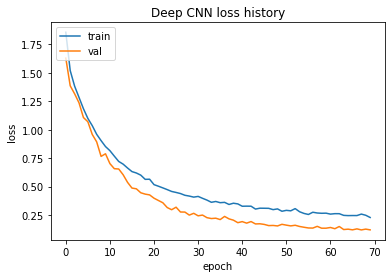

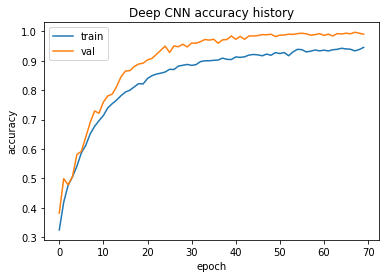

In [11]:
# print loss graph
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Deep CNN loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# print accuracy graph
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Deep CNN accuracy history')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()